In [1]:
# Librerias que se cargan en python
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import string

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
print('Done')


Done


First of all,  I analyse lost data

In [2]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


There are a high percentage of lost data. So I concatenate the train and test data in a set called 'DATA', and then i try to estimate lost values (especially Age an Cabin features)

In [3]:
# Columns List
#['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch','Ticket', 'Fare', 'Cabin', 'Embarked']
data = pd.concat([train_data, test_data], axis = 0, join='outer')
data.reset_index(inplace=True)
#print(data.isnull().sum())
print('Done')
#Datos perdidos
#Survived        418
#Age             263
#Fare              1
#Cabin          1014
#Embarked          2


Done


There are three groups with a considerable empty data: Age, Cabin and Survived. The main goal is to predict the survived values. But first, we estimate age and cabin values. Now, concretely i will estimate age values.
I separate the data in the foolowing way:
Data with age features but without Cabin and Survived
Data with age and Cabin features but without Survived
Data with age and Survived features but without Cabin
Data with all features
I exclude of my analysis fare and embarked values.

Before to begin the analysis, it necesary to handle the categorical values. After reading the advice about features treatment, I use the function to get the titles names and Deck Cabins. I define new features in the way that was recommended in the data section

In [4]:
# I get a list with last names
Last_name = set()
for i in data['Name']:
    Last_name.add(i.split(",")[0])
last_name = list(Last_name)


In [5]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        big_string = str(big_string)
        if big_string.find(substring) != -1:
            return substring
    return np.nan


def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
def new_features(data):
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']
    data['Title'] = data['Name'].map(lambda x: substrings_in_string(x, title_list))
    data['Title'] = data.apply(replace_titles, axis=1)

    data['Family_Size']=data['SibSp']+data['Parch']
   
    data['Fare_Per_Person']=data['Fare']/(data['Family_Size']+1)
    
    data['Last Name']=data['Name'].map(lambda x: substrings_in_string(x, last_name))

new_features(data)


It´s worth to visualize the Age distribution of all passengers

[[<matplotlib.axis.YTick at 0x7f0ba541bc10>,

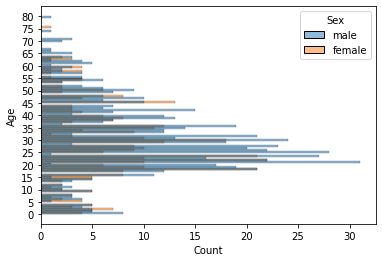

In [6]:
sns.histplot(data=data, y='Age', hue='Sex', bins = 100 ).set(yticks=list(range(0,85,5)))

At this point, it is necesary to split the age data in several subset: age<18 (Young), age <36, >18 (Adult), Age<53, >36 (Adult2), age>53 (elder). This criteria is based on the age histogram, and i define this just in a visual analysis

In [7]:
pd.options.display.max_rows = None
def convert_age(data):
    if  data['Age'] <= 18:
        return 'Young'
    elif 18 < data['Age'] <=36:
        return 'Adult'
    elif 36 < data['Age'] <=53:
        return 'Adult2'
    elif 53 < data['Age']:
        return 'Elder'
a = data.loc[(data['Title']=='Mr')&(data['Pclass']==3), 'Age']
a.fillna(a.mean(), inplace=True)
data.loc[(data['Title']=='Mr')&(data['Pclass']==3), 'Age'] = a

a = data.loc[(data['Title']=='Mr')&(data['Pclass']==1)&(data['Embarked']!='Q'), 'Age']
a.fillna(a.mean(), inplace=True)
data.loc[(data['Title']=='Mr')&(data['Pclass']==1)&(data['Embarked']!='Q'), 'Age'] = a

data['Age_category'] = data.apply(convert_age, axis=1)
data.isnull().sum()


index                 0
PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                 100
SibSp                 0
Parch                 0
Ticket                0
Fare                  1
Cabin              1014
Embarked              2
Title                 0
Family_Size           0
Fare_Per_Person       1
Last Name             0
Age_category        100
dtype: int64

Now i woul define a new feature called 'Travel_with'. This feature says if a person travel alone, with a group (more than 1 person), with a family or just with a partner. 


In [8]:
# I create a dict with tickets values: the key will be the frecuency and the value the ticket
t_values = data['Ticket'].to_list()
t_values = sorted(t_values)
dicc = {}
for val in t_values:
    if val in dicc.keys():
        dicc[val] = dicc[val] + 1
    else:
        dicc[val] = 1

#Now I create a column that show if somewho else has the same ticket
data['Number_Tickets']=data['Ticket'].apply(lambda x: dicc[x])

# I define the function travel_with
def travel_with(dat):
    if ((dat['Family_Size']!=0) & (dat['Number_Tickets']!=0)):
        return "Family"
    elif ((dat['Family_Size']==0) & (dat['Number_Tickets']>2)):
        return "Group"
    elif ((dat['Family_Size']==0) & (dat['Number_Tickets']==2)):
        return "Partner"
    else:
        return "Alone"
                  
data['Traveling_with']=data.apply(travel_with, axis=1)



In [9]:
data.columns.values

array(['index', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title',
       'Family_Size', 'Fare_Per_Person', 'Last Name', 'Age_category',
       'Number_Tickets', 'Traveling_with'], dtype=object)

I plot age vs title, checking the class

Data considering Embarked
Data considering Family_Size
Data considering Traveling_with


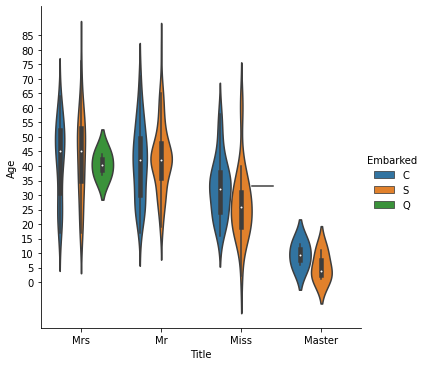

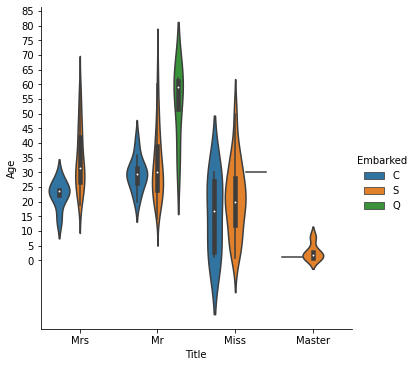

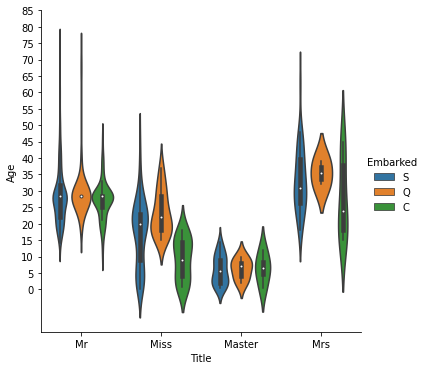

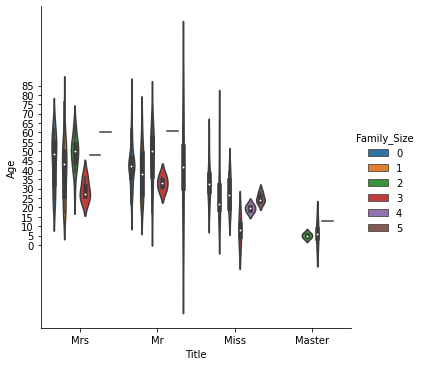

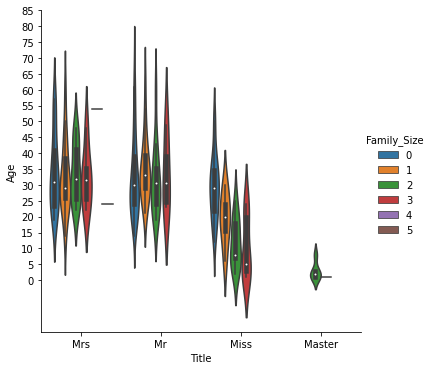

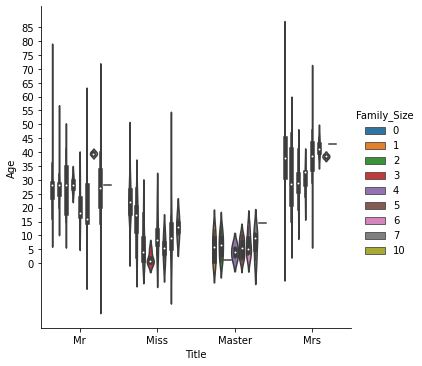

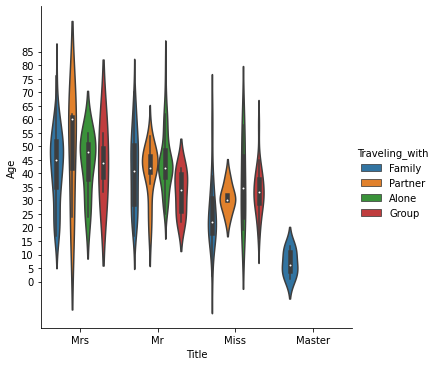

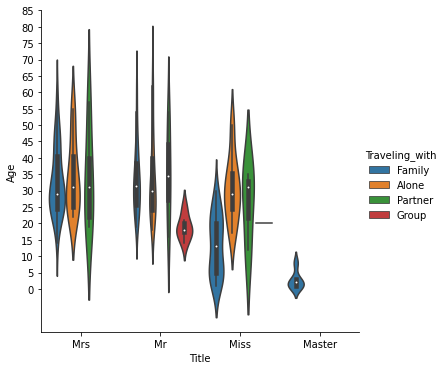

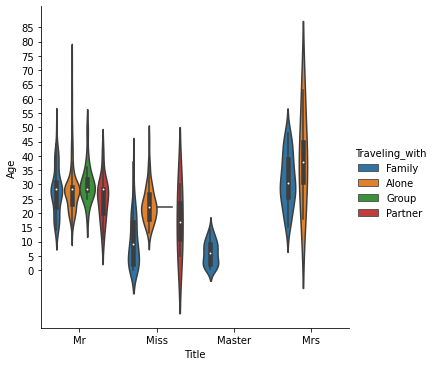

In [10]:
for i in ['Embarked', 'Family_Size','Traveling_with']:
    print("Data considering {0}".format(i))
    sns.catplot(data=data[data['Pclass']==1], x = 'Title', y = 'Age', kind = 'violin', hue = i).set(yticks=list(range(0,90,5)))
    sns.catplot(data=data[data['Pclass']==2], x = 'Title', y = 'Age', kind = 'violin', hue = i).set(yticks=list(range(0,90,5)))
    sns.catplot(data=data[data['Pclass']==3], x = 'Title', y = 'Age', kind = 'violin', hue = i).set(yticks=list(range(0,90,5)))

Now I will work on cabin data. The idea is that persons with same ticket are in same Cabin

In [11]:
a = data.groupby(by='Ticket').groups
l = list(a.keys())
long = len(l)
print(data['Cabin'].isnull().sum())

for i in range(long):
    if not all(data.loc[a[l[i]],'Cabin'].isnull()):
        if not all(data.loc[a[l[i]],'Cabin'].isnull()):
            x = data.loc[a[l[i]],'Cabin']
            val = list(x.mode())
            x.fillna(value=val[0], inplace=True)
            data.loc[a[l[i]],'Cabin'] = x
print(data.isnull().sum())
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'x']
data['Deck']=data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

1014
index                0
PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                100
SibSp                0
Parch                0
Ticket               0
Fare                 1
Cabin              998
Embarked             2
Title                0
Family_Size          0
Fare_Per_Person      1
Last Name            0
Age_category       100
Number_Tickets       0
Traveling_with       0
dtype: int64


Also I plot the Cabin distribution considering the clas

Rate of loss data in cabin for First class: 0.16718266253869968
Rate of loss data in cabin for First class: 0.9133574007220217
Rate of loss data in cabin for First class: 0.9746121297602257


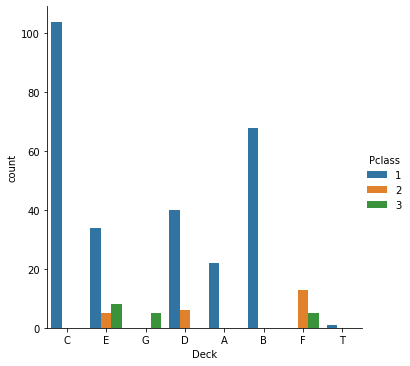

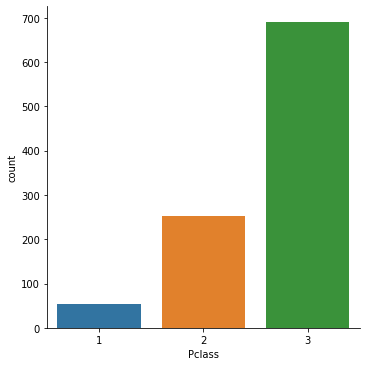

In [12]:
sns.catplot(data=data, kind='count', x='Deck', hue='Pclass')
sns.catplot(data=data[data['Deck'].isnull()], kind='count', x='Pclass')
#Loss data
for i in [1,2,3]:
    L = len(data[data['Pclass']==i]['Deck'])
    loss_f = data[data['Pclass']==i]['Deck'].isnull().sum()
    print("Rate of loss data in cabin for First class: {0}".format(loss_f/L))




I see that first class Travel in A, B and C cabin, and the loss data of this are relative low. In relation with deck, Isee that A, B and C has only first class, D has first and second, and i can suppouse there was people ofthird class, because there a high loss data rate. Finally, F and G just have second and third class. I woul plot the Deck vs fare per person. 

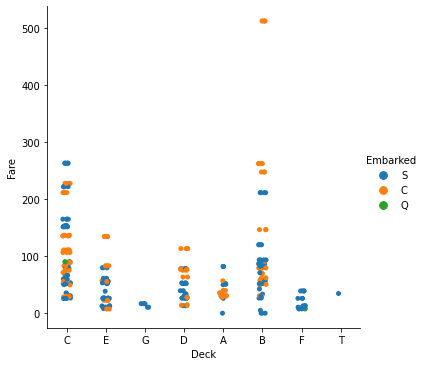

In [13]:
sns.catplot(data=data, x= 'Deck', y='Fare', hue='Embarked')


I will train data to estimate loos values of Cabin
I just consider fare, family size, embarked, pclass. I divide this train data in 2 set: In one of them I consider survived

In [14]:
emn = data['Embarked']
vale = list(emn.mode())
emn.fillna(value=vale[0], inplace=True)
data['Embarked'] = emn

fr = data['Fare']
valf = list(fr.mode())
fr.fillna(value=valf[0], inplace=True)
data['Fare'] = fr


data_cab_s = data[data['Survived'].notnull()]
data_cab_s = data_cab_s[data_cab_s['Deck'].notnull()]

X_cab_s = data_cab_s[['Survived', 'Pclass', 'Sex',
        'Fare', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']]
X_cab_s = pd.get_dummies(X_cab_s)
X_cab_s = X_cab_s.astype('int32')

Y_cab_s =pd.get_dummies(data_cab_s['Deck'])

x_cab_s = data[data['Survived'].notnull()]
x_cab_s = x_cab_s[x_cab_s['Deck'].isnull()]
x_cab_s = pd.get_dummies(x_cab_s[['Survived', 'Pclass', 'Sex',
        'Fare', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']])
x_cab_s = x_cab_s.astype('int32')



from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_cab_s, Y_cab_s)
val = clf.predict(x_cab_s)
pred = pd.DataFrame(val, columns=Y_cab_s.columns.values)
pred = pred.idxmax(axis=1)


data.loc[data['Survived'].notnull() & data['Deck'].isnull(), 'Deck'] = list(pred)


I do the same but without survived feature

In [15]:
data_cab_s = data[data['Survived'].isnull()]
data_cab_s = data_cab_s[data_cab_s['Deck'].notnull()]

X_cab_s = data_cab_s[[ 'Pclass', 'Sex',
        'Fare', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']]
X_cab_s = pd.get_dummies(X_cab_s)
X_cab_s = X_cab_s.astype('int32')

Y_cab_s =pd.get_dummies(data_cab_s['Deck'])

x_cab_s = data[data['Survived'].isnull()]
x_cab_s = x_cab_s[x_cab_s['Deck'].isnull()]
x_cab_s = pd.get_dummies(x_cab_s[['Pclass', 'Sex',
        'Fare', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']])


from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_cab_s, Y_cab_s)
val = clf.predict(x_cab_s)
pred = pd.DataFrame(val, columns=Y_cab_s.columns.values)
pred = pred.idxmax(axis=1)

data.loc[data['Survived'].isnull() & data['Deck'].isnull(), 'Deck'] = list(pred)
data.isnull().sum()


index                0
PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                100
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              998
Embarked             0
Title                0
Family_Size          0
Fare_Per_Person      1
Last Name            0
Age_category       100
Number_Tickets       0
Traveling_with       0
Deck                 0
dtype: int64

In [16]:
data.isnull().sum()

index                0
PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                100
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              998
Embarked             0
Title                0
Family_Size          0
Fare_Per_Person      1
Last Name            0
Age_category       100
Number_Tickets       0
Traveling_with       0
Deck                 0
dtype: int64

# **Analizo los valores valores perdidos de Age de los valores data**

In [17]:
t_data = data[data['Age'].notnull()]
t_data = t_data[t_data['Survived'].notnull()]
t_dataX = t_data[['Survived', 'Pclass', 'Sex',
        'Fare','Deck', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']]
t_dataX = pd.get_dummies(t_dataX)
t_dataX = t_dataX.astype('int32')
t_dataY = t_data['Age']
t_dataY = t_dataY.astype('int32')


r_data = data[data['Age'].isnull()]
r_data = r_data[r_data['Survived'].notnull()]
r_dataX = r_data[['Survived', 'Pclass', 'Sex',
        'Fare', 'Deck', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']]
r_dataX = pd.get_dummies(r_dataX)
r_dataX = r_dataX.astype('int32')
#Using get dummies, usually I get different training and set features. In the next line i solve this

features = list(set(t_dataX.columns.values) & set(r_dataX.columns.values))

t_dataX = t_dataX[features]
r_dataX = r_dataX[features]



from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(t_dataX, t_dataY)


data.loc[(data['Age'].isnull() & data['Survived'].notnull()), 'Age'] = clf.predict(r_dataX)




In [18]:
t_data = data[data['Age'].notnull()]
t_data = t_data[t_data['Survived'].isnull()]
t_dataX = t_data[['Pclass', 'Sex',
        'Fare','Deck', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']]
t_dataX = pd.get_dummies(t_dataX)
t_dataX = t_dataX.astype('int32')
t_dataX.drop(labels=['Deck_A', 'Deck_G', 'Deck_F', 'Deck_B', 'Deck_C', 'Traveling_with_Group'], axis=1, inplace=True)
t_dataY = t_data['Age']
t_dataY = t_dataY.astype('int32')

r_data = data[data['Age'].isnull()]
r_data = r_data[r_data['Survived'].isnull()]
r_dataX = r_data[['Pclass', 'Sex',
        'Fare', 'Deck', 'Embarked', 'Title',
       'Family_Size',
       'Number_Tickets', 'Traveling_with']]
r_dataX = pd.get_dummies(r_dataX)
r_dataX = r_dataX.astype('int32')


features = list(set(t_dataX.columns.values) & set(r_dataX.columns.values))

t_dataX = t_dataX[features]
r_dataX = r_dataX[features]

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(t_dataX, t_dataY)

data.loc[(data['Age'].isnull() & data['Survived'].isnull()), 'Age'] = clf.predict(r_dataX)
data.isnull().sum()

index                0
PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              998
Embarked             0
Title                0
Family_Size          0
Fare_Per_Person      1
Last Name            0
Age_category       100
Number_Tickets       0
Traveling_with       0
Deck                 0
dtype: int64


# **Agregar una features extras**

In [19]:
data.loc[data['Age_category'].isnull(), 'Age_category'] = data[data['Age_category'].isnull()].apply(convert_age, axis=1)



In [20]:
data.isnull().sum()

index                0
PassengerId          0
Survived           418
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              998
Embarked             0
Title                0
Family_Size          0
Fare_Per_Person      1
Last Name            0
Age_category         0
Number_Tickets       0
Traveling_with       0
Deck                 0
dtype: int64

# **Genero el modelo con random forest** 

In [21]:
pd.options.display.max_rows = 30
from sklearn.ensemble import RandomForestClassifier

y = data.loc[data["Survived"].notnull(), 'Survived']

features = ['PassengerId','Age','Sex','Pclass','Fare','Embarked', 'SibSp', 'Parch','Title', 'Family_Size', 'Age_category', 'Traveling_with', 'Deck']
X = pd.get_dummies(data[data['Survived'].notnull()][features])
X_test = pd.get_dummies(data[data['Survived'].isnull()][features])

features = list(set(X.columns.values)&set(X_test.columns.values))
X = X[features]
X_test = X_test[features]




model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)
predictions = predictions.astype('int32')
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission3.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!
